## Adding SNe to CoCo
___

This notebook will go through adding a SN to the CoCo template framework.

In [74]:
%matplotlib inline
# %matplotlib notebook

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3
        
from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import os
import numpy as np
from astropy.table import Table, Column
from collections import OrderedDict

import pycoco as pcc

## Download SN
---
The example that I will go through is probably the simplest one - from a JSON that I have downloaded from http://sne.space contaning the information for SN2015U.

In [75]:
import json

In [76]:
data_dir = "/Users/berto/data/CoreCollapse/SNe/"
out_data_dir = "/Users/berto/data/CoreCollapse/data/"
snname = "SN2015U"
path = os.path.join(data_dir, "SN2015U.json")

sndict = json.load(open(path, 'r'))[snname]

In [77]:
sndict.keys()

dict_keys(['schema', 'name', 'sources', 'alias', 'claimedtype', 'comovingdist', 'dec', 'discoverdate', 'discoverer', 'ebv', 'host', 'hostdec', 'hostoffsetang', 'hostoffsetdist', 'hostra', 'hostvelocity', 'lumdist', 'maxabsmag', 'maxappmag', 'maxband', 'maxdate', 'maxvisualabsmag', 'maxvisualappmag', 'maxvisualband', 'maxvisualdate', 'ra', 'redshift', 'velocity', 'photometry', 'spectra'])

In [78]:
sndict["redshift"][0]["value"]

'0.01379'

In [79]:
len(sndict["spectra"])

21

In [80]:
S1 = sndict["spectra"][0]

In [81]:
S1.keys()

dict_keys(['time', 'filename', 'instrument', 'observer', 'reducer', 'snr', 'u_errors', 'u_fluxes', 'u_time', 'u_wavelengths', 'data', 'source'])

In [82]:
w = np.array(S1["data"], dtype=np.float64).T[0]
f = np.array(S1["data"], dtype=np.float64).T[1]

In [83]:
f

array([ 0.17578192,  0.24098685,  0.15754801, ...,  0.15758722,
        0.14430489,  0.1320765 ])

In [84]:
from astropy.table import Table, Column, Row
import astropy.units as u


In [85]:
wavelength = Column(w, name = ("wavelength"), unit=u.Angstrom)
flux = Column(f, name = ("flux"), unit=u.cgs.erg / u.si.cm ** 2 / u.si.s / u.angstrom)

In [86]:
Table([wavelength, flux])

wavelength,flux
Angstrom,erg / (Angstrom cm2 s)
float64,float64
3440.0,0.17578192
3442.0,0.24098685
3444.0,0.15754801
3446.0,0.1271165
3448.0,0.16798687
3450.0,0.15301467
3452.0,0.11438128
3454.0,0.14230451


In [87]:
spec_dict_list = sndict["spectra"]
for s in spec_dict_list:
    print(s["time"], s["filename"])

57068.3 psn0728+3349-20150215.256-ui.flm
57068.3 psn0728+3349.gal-20150215.256-ui.flm
57070.0 PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii
57070.0 SN2015U_2015-02-17_20:01:56_Asiago.ascii
57071.0 PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii
57071.2 psn0728+3349-20150218.211-ir.flm
57071.2 psn0728+3349.gal-20150218.211-ir.flm
57072.0 PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii
57074.2 psn0728+3349-20150221.207-ui.flm
57074.2 psn0728+3349.gal-20150221.207-ui.flm
57074.2 psn0728+3349.sn+gal-20150221.207-ui.flm
57075.0 PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii
57076.0 PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii
57077.2 psn0728+3349-20150224.224-ui.flm
57077.4 psn0728+3349-20150224.414-uh.flm
57078.0 PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii
57078.2 psn0728+3349-20150225.171-ui.flm
57080.3 psn0728+3349-20150227.34.deimos.flm
57081.0 PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii
57084.0 PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii
57092.

In [88]:
len(np.unique([s["time"] for s in spec_dict_list])) == len(spec_dict_list)

False

In [89]:
skip_spec = ["psn0728+3349.gal-20150215.256-ui.flm",
             "psn0728+3349.gal-20150218.211-ir.flm",
             "psn0728+3349.gal-20150221.207-ui.flm",
             "psn0728+3349.sn+gal-20150221.207-ui.flm"]

In [90]:
out_dict = OrderedDict()

uncombined=np.array([])
spec_filenames = [spec["filename"] for spec in sndict["spectra"]]
# print(spec_filenames)
spec_dir = os.path.join(out_data_dir, "spectra/SN2015U/")

# if not os.path.isdir(os.path.abspath(os.path.join(spec_dir, os.path.pardir))):
#     os.mkdir(os.path.abspath(os.path.join(spec_dir, os.path.pardir)))
# if not os.path.isdir(spec_dir):
#     os.mkdir(spec_dir)
    
good_spec_filenames = [spec for spec in spec_filenames if spec not in skip_spec]

In [91]:
len(good_spec_filenames)

17

psn0728+3349-20150215.256-ui.flm
0
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150215.256-ui.flm
has data
redshift  0.01379
57068.3


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150215.256-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


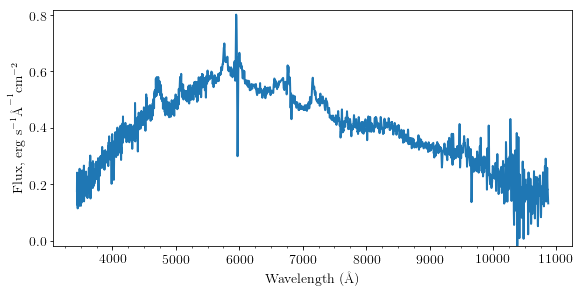

PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii
2
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii
has data
redshift  0.01379
57070.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


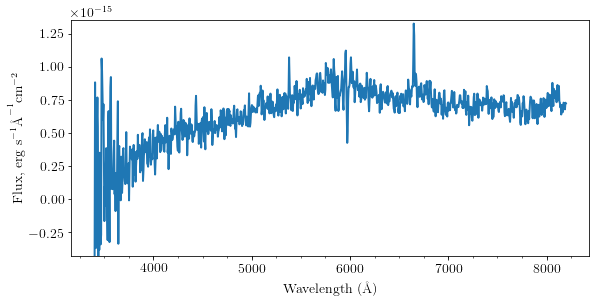

SN2015U_2015-02-17_20:01:56_Asiago.ascii
3
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii
has data
redshift  0.01379
57070.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


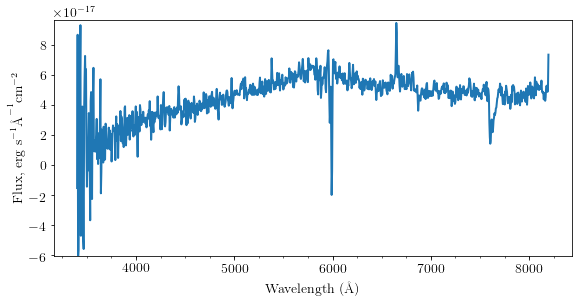

PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii
4
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii
has data
redshift  0.01379
57071.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


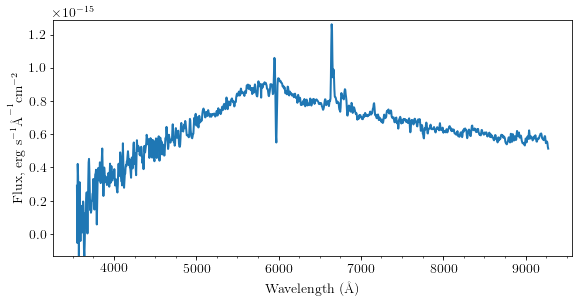

psn0728+3349-20150218.211-ir.flm
5
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150218.211-ir.flm
has data
redshift  0.01379
57071.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150218.211-ir.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


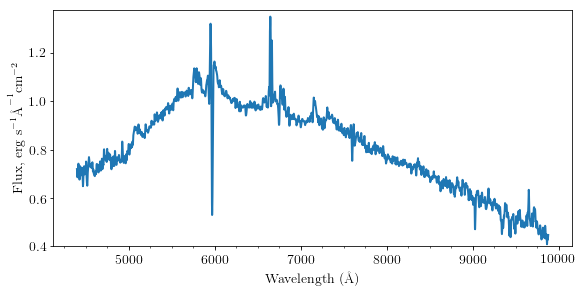

PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii
7
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii
has data
redshift  0.01379
57072.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


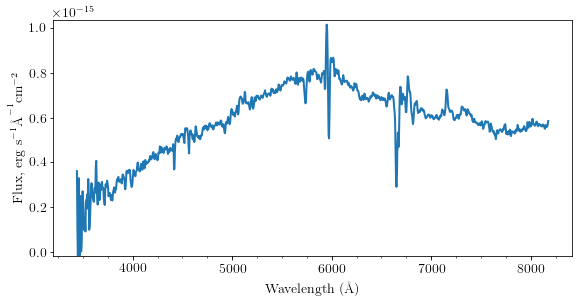

psn0728+3349-20150221.207-ui.flm
8
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150221.207-ui.flm
has data
redshift  0.01379
57074.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150221.207-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


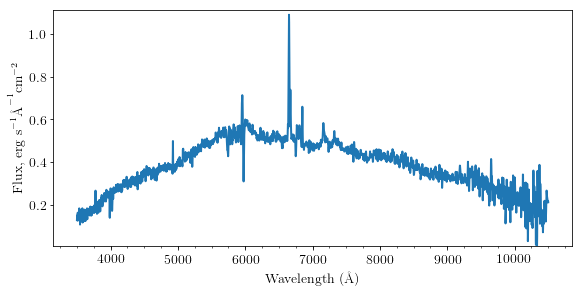

PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii
11
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii
has data
redshift  0.01379
57075.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


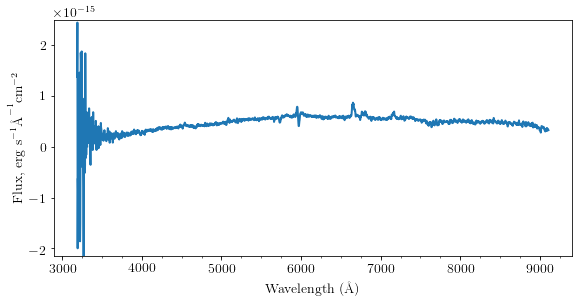

PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii
12
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii
has data
redshift  0.01379
57076.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


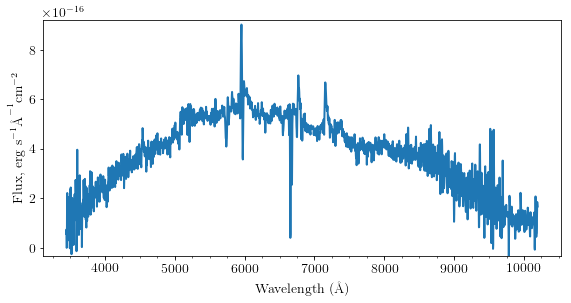

psn0728+3349-20150224.224-ui.flm
13
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150224.224-ui.flm
has data
redshift  0.01379
57077.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150224.224-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


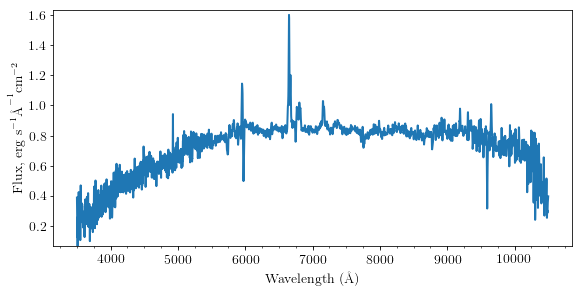

psn0728+3349-20150224.414-uh.flm
14
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150224.414-uh.flm
has data
redshift  0.01379
57077.4


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150224.414-uh.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


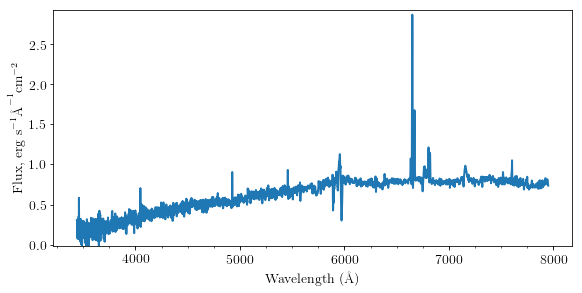

PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii
15
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii
has data
redshift  0.01379
57078.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150225_TNG_LRS_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


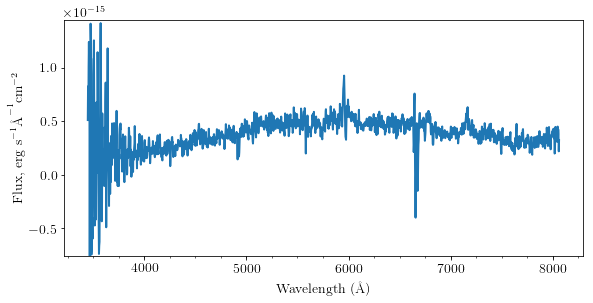

psn0728+3349-20150225.171-ui.flm
16
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150225.171-ui.flm
has data
redshift  0.01379
57078.2


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150225.171-ui.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


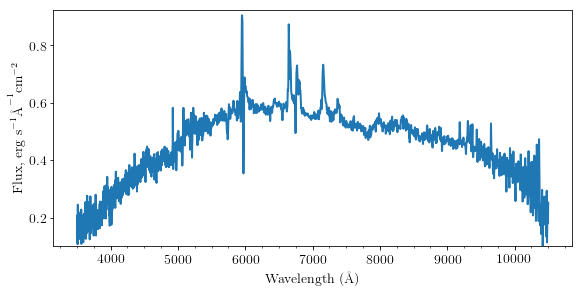

psn0728+3349-20150227.34.deimos.flm
17
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150227.34.deimos.flm
has data
redshift  0.01379
57080.3


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150227.34.deimos.flm. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


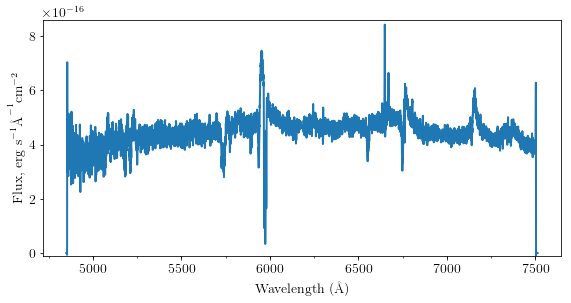

PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii
18
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii
has data
redshift  0.01379
57081.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150228_TNG_LRS_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


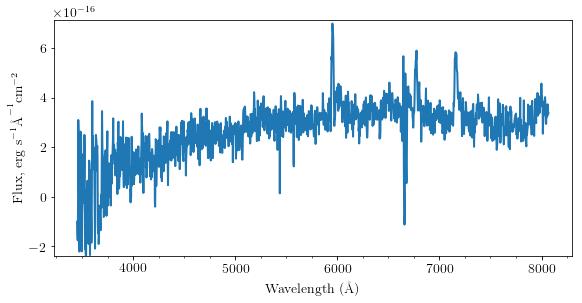

PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii
19
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii
has data
redshift  0.01379
57084.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150303_NOT_ALFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


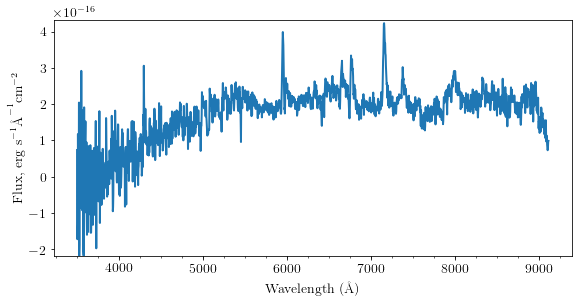

PSNJ07285387p3349106_20150311_NOT_ALFOSC_cal.ascii
20
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150311_NOT_ALFOSC_cal.ascii
has data
redshift  0.01379
57092.0


/Users/berto/Code/verbose-enigma/pycoco/classes.py:490: UserWarning: Found existing file matching /Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150311_NOT_ALFOSC_cal.ascii. Run with squash = True to overwrite
  filename) + ". Run with squash = True to overwrite")


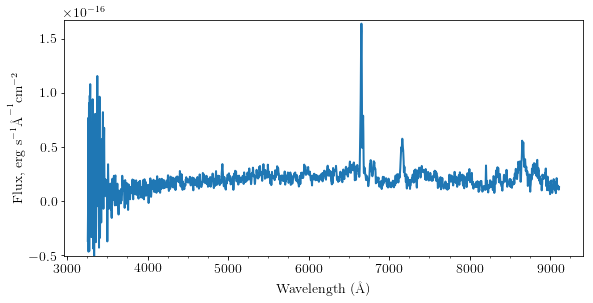

In [92]:
# for spec_file in np.array(spec_filenames):
for spec_file in np.array(good_spec_filenames):
    print(spec_file)
    
    w = np.where(np.array(spec_filenames) == spec_file)[0][0]
    print(w)
    
    wavl = np.array(spec_dict_list[w]["data"], dtype=np.float64).T[0]
    flux = np.array(spec_dict_list[w]["data"], dtype=np.float64).T[1]

    wavelength = Column(wavl, name = ("wavelength"), unit=u.Angstrom)
    flux = Column(flux, name = ("flux"), unit=u.cgs.erg / u.si.cm ** 2 / u.si.s / u.angstrom)

    spec_table = Table([wavelength, flux])

    s = pcc.SpectrumClass()

    s.load_table(spec_table, path="")
    print(os.path.join(spec_dir, spec_file))
    s.save(spec_file, path=spec_dir, )
    out_dict = OrderedDict()
    out_dict["filename"] = os.path.join(spec_dir, spec_file)
    out_dict["time"] = np.float64(spec_dict_list[w]["time"])
    out_dict["redshift"] = np.float64(sndict["redshift"][0]["value"])
    print("redshift ", out_dict["redshift"])
    out_dict["snname"] = snname
    print(spec_dict_list[w]["time"])
    uncombined = np.append(uncombined, out_dict)
    
    s.plot()

In [93]:
out_array = uncombined

In [94]:
out_array

array([ OrderedDict([('filename', '/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150215.256-ui.flm'), ('time', 57068.300000000003), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii'), ('time', 57070.0), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/data/CoreCollapse/data/spectra/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii'), ('time', 57070.0), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii'), ('time', 57071.0), ('redshift', 0.01379), ('snname', 'SN2015U')]),
       OrderedDict([('filename', '/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150218.211-ir.flm'), ('time', 57071.199999999997), ('redshift', 0.01379), ('snnam

In [95]:
keys = ["filename",
        "snname",
        "time",
        "redshift"]
columns = []
for key in keys:
    columns.append([i[key] for i in out_array])

In [96]:
keys[2] = "MJD"
list_table = Table(columns, names = keys)

In [97]:
list_table.add_index("MJD")
list_table.sort()

In [98]:
list_table

filename,snname,MJD,redshift
str105,str7,float64,float64
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150215.256-ui.flm,SN2015U,57068.3,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150217_Ekar182_AFOSC_cal.ascii,SN2015U,57070.0,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/SN2015U_2015-02-17_20:01:56_Asiago.ascii,SN2015U,57070.0,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150218_Ekar182_AFOSC_cal.ascii,SN2015U,57071.0,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150218.211-ir.flm,SN2015U,57071.2,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150219_Ekar182_AFOSC_cal.ascii,SN2015U,57072.0,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/psn0728+3349-20150221.207-ui.flm,SN2015U,57074.2,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150222_NOT_ALFOSC_cal.ascii,SN2015U,57075.0,0.01379
/Users/berto/data/CoreCollapse/data/spectra/SN2015U/PSNJ07285387p3349106_20150223_TNG_LRS_cal.ascii,SN2015U,57076.0,0.01379


In [99]:
list_out_path = os.path.join(pcc.defaults._default_list_dir_path, snname+".list")
list_table.write(list_out_path, format="ascii.no_header")

In [100]:
info = pcc.classes.InfoClass()
info.load()

In [102]:
info._data

snname,z_obs,mu,RA,Dec,Type,z_distmod,SkyCoords
,,,,,,,"deg,deg"
str9,float64,float64,str13,str13,str3,float64,object
SN1993J,-0.0001,27.82,09:55:24.7747,+69:01:13.702,IIb,0.000846738572565,"148.85322791666664,69.02047277777778"
SN1994I,0.0015,29.5,13:29:54.072,+47:11:30.50,Ic,0.00183405936245,"202.47529999999995,47.191805555555554"
SN1996cb,0.0024,30.69,11:03:41.98,+28:54:13.7,IIb,0.00316927429656,"165.92491666666666,28.903805555555554"
SN1998bw,0.0085,32.69,19:35:03.17,-52:50:46.1,Ic,0.00793139066351,"293.76320833333324,-52.846138888888895"
SN1999dn,0.0093,32.44,23:36:14.70,+02:09:08.8,Ib,0.00707356943452,"354.06125,2.1524444444444444"
SN2002ap,0.0022,29.76,01:36:23.85,+15:45:13.2,Ic,0.00206697015014,"24.099375,15.753666666666666"
SN2003jd,0.0188,34.33,23:21:03.38,-04:53:45.5,Ic,0.01676453466,"350.2640833333333,-4.8959722222222215"
SN2004aw,0.0159,34.48,11:57:50.24,+25:15:55.1,Ic,0.0179472672379,"179.45933333333332,25.265305555555557"


In [103]:
small_table = info._data[("snname", "z_obs", "mu", "RA", "Dec", "Type", "z_distmod")]

In [104]:
small_table

snname,z_obs,mu,RA,Dec,Type,z_distmod
str9,float64,float64,str13,str13,str3,float64
SN1993J,-0.0001,27.82,09:55:24.7747,+69:01:13.702,IIb,0.000846738572565
SN1994I,0.0015,29.5,13:29:54.072,+47:11:30.50,Ic,0.00183405936245
SN1996cb,0.0024,30.69,11:03:41.98,+28:54:13.7,IIb,0.00316927429656
SN1998bw,0.0085,32.69,19:35:03.17,-52:50:46.1,Ic,0.00793139066351
SN1999dn,0.0093,32.44,23:36:14.70,+02:09:08.8,Ib,0.00707356943452
SN2002ap,0.0022,29.76,01:36:23.85,+15:45:13.2,Ic,0.00206697015014
SN2003jd,0.0188,34.33,23:21:03.38,-04:53:45.5,Ic,0.01676453466
SN2004aw,0.0159,34.48,11:57:50.24,+25:15:55.1,Ic,0.0179472672379
SN2005bf,0.0189,34.73,10:23:56.99,-03:11:29.3,Ib,0.0201040285508


In [105]:
sndict.keys()

dict_keys(['schema', 'name', 'sources', 'alias', 'claimedtype', 'comovingdist', 'dec', 'discoverdate', 'discoverer', 'ebv', 'host', 'hostdec', 'hostoffsetang', 'hostoffsetdist', 'hostra', 'hostvelocity', 'lumdist', 'maxabsmag', 'maxappmag', 'maxband', 'maxdate', 'maxvisualabsmag', 'maxvisualappmag', 'maxvisualband', 'maxvisualdate', 'ra', 'redshift', 'velocity', 'photometry', 'spectra'])

In [106]:
sndict["lumdist"]

[{'derived': True,
  'source': '2,4,9,10,12,14,16',
  'u_value': 'Mpc',
  'value': '61.673'}]

In [108]:
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Distance

mu = 33.92 ## from NED -- https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=NGC+2388&extend=no&hconst=70.5&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES#NR_Distances_0
d = Distance(distmod=mu)

z_distmod = d.z

In [109]:
(snname, sndict["redshift"][0]["value"], mu, sndict["ra"][0]["value"], sndict["dec"][0]["value"], sndict["claimedtype"][0]["value"].replace("/", ""), z_distmod)

('SN2015U',
 '0.01379',
 33.92,
 '07:28:53.87',
 '+33:49:10.6',
 'Ibn',
 0.013910509585698595)

In [110]:
small_table.add_row((snname, sndict["redshift"][0]["value"], mu, sndict["ra"][0]["value"], sndict["dec"][0]["value"], sndict["claimedtype"][0]["value"].replace("/", ""), z_distmod))

In [111]:
small_table

snname,z_obs,mu,RA,Dec,Type,z_distmod
str9,float64,float64,str13,str13,str3,float64
SN1993J,-0.0001,27.82,09:55:24.7747,+69:01:13.702,IIb,0.000846738572565
SN1994I,0.0015,29.5,13:29:54.072,+47:11:30.50,Ic,0.00183405936245
SN1996cb,0.0024,30.69,11:03:41.98,+28:54:13.7,IIb,0.00316927429656
SN1998bw,0.0085,32.69,19:35:03.17,-52:50:46.1,Ic,0.00793139066351
SN1999dn,0.0093,32.44,23:36:14.70,+02:09:08.8,Ib,0.00707356943452
SN2002ap,0.0022,29.76,01:36:23.85,+15:45:13.2,Ic,0.00206697015014
SN2003jd,0.0188,34.33,23:21:03.38,-04:53:45.5,Ic,0.01676453466
SN2004aw,0.0159,34.48,11:57:50.24,+25:15:55.1,Ic,0.0179472672379
SN2005bf,0.0189,34.73,10:23:56.99,-03:11:29.3,Ib,0.0201040285508


In [112]:
outfile = pcc.defaults._default_info_path.replace(".dat", "_new.dat")
small_table.write(outfile, format="ascii.commented_header")


# Photometry
---


In [113]:
sndict["photometry"]

[{'band': 'clear',
  'e_magnitude': '0.1515',
  'magnitude': '18.0616',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57064.24',
  'u_time': 'MJD'},
 {'band': 'clear',
  'e_magnitude': '0.0646',
  'magnitude': '16.8465',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57066.22',
  'u_time': 'MJD'},
 {'band': 'B',
  'e_magnitude': '0.1749',
  'magnitude': '17.7117',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'R',
  'e_magnitude': '0.0592',
  'magnitude': '16.4640',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'V',
  'e_magnitude': '0.0891',
  'magnitude': '16.9832',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'clear',
  'e_magnitude': '0.0542',
  'magnitude': '16.5726',
  'source': '1,13',
  'telescope': 'KAIT',
  'time': '57067.35',
  'u_time': 'MJD'},
 {'band': 'I',
  'e_magnitude': '0.0766',
  'magnitude': '16.1834',
  

In [114]:
phot_dict_list = sndict["photometry"]
new_phot_dict_list = []
for i in phot_dict_list:
    out_dict = OrderedDict()
    
    out_dict["MJD"] = i["time"]
    out_dict["mag"] = i["magnitude"]
    out_dict["dmag"] = i["e_magnitude"]
    out_dict["filter"] = i["band"]
    
    new_phot_dict_list.append(out_dict)

In [115]:
phot_table=Table(rows=new_phot_dict_list)

In [117]:
phot_table

MJD,dmag,filter,mag
str8,str6,str5,str7
57064.24,0.1515,clear,18.0616
57066.22,0.0646,clear,16.8465
57067.35,0.1749,B,17.7117
57067.35,0.0592,R,16.4640
57067.35,0.0891,V,16.9832
57067.35,0.0542,clear,16.5726
57067.36,0.0766,I,16.1834
57068.21,0.1072,B,17.6548
57068.22,0.0561,I,16.2318


In [118]:
w = np.where(phot_table["filter"] != "clear")
# print(w)

In [119]:
phot_table_filtered = phot_table[w]

In [120]:
# pcc.calc_AB_zp?
filt_dict = OrderedDict()

for filter_name in np.unique(phot_table_filtered["filter"]):
#     filter_name = "Bessell"+filter_name
#     filter_dir_path = os.path.join(pcc.defaults._default_filter_dir_path, "Bessell"+filter_name+".dat")
    print(filter_name)
    filter_object = pcc.classes.FilterClass()
    filter_object.load(path=os.path.join(pcc.defaults._default_filter_dir_path, "Bessell"+filter_name+".dat"), fmt="ascii",
                      name="Bessell"+filter_name)
    filter_object.calculate_AB_zp()
    filt_dict["Bessell"+filter_name]=filter_object

B
I
R
V


In [121]:
phot_table_filtered["filter"] = Column(list(map(lambda x: "Bessell"+x, phot_table_filtered["filter"])))

In [122]:
phot_table_filtered

MJD,dmag,filter,mag
str8,str6,str8,str7
57067.35,0.1749,BessellB,17.7117
57067.35,0.0592,BessellR,16.4640
57067.35,0.0891,BessellV,16.9832
57067.36,0.0766,BessellI,16.1834
57068.21,0.1072,BessellB,17.6548
57068.22,0.0561,BessellI,16.2318
57068.22,0.0277,BessellR,16.4146
57068.22,0.0476,BessellV,16.8599
57070.19,0.0874,BessellB,17.6547


In [123]:
# filt_dict["BessellB"].zp_AB
phot_table_filtered["zp_AB"] = Column(list(map(lambda x: filt_dict[x].zp_AB, phot_table_filtered["filter"])), name="zp_AB")

In [124]:
phot_table_filtered["zp_AB"] phot_table_filtered["mag"]

SyntaxError: invalid syntax (<ipython-input-124-4b1bc2edf0be>, line 1)

In [ ]:
SN = pcc.classes.SNClass(snname)
SN.load_phot()
SN.plot_lc()

In [ ]:
list_file_path = "/Users/berto/Code/CoCo/lists/"+snname+".list"
# list_file_path = "/Users/berto/data/CoreCollapse/SNe/SN2010as.list"
SN.load_list(path=list_file_path)

In [ ]:
SN.load_spec()

In [ ]:
SN.plot_spec()

In [ ]:
SN.spec

In [ ]:
fit_path = "/Users/berto/Code/CoCo/recon/"+snname+".dat"
SN.get_lcfit(fit_path)

SN.plot_lc()

In [ ]:
# pcc.functions.run_specfit(list_file_path)